# Random Forest Model for Climate Change Predictions

We use a random forest model to predict to predict temperature, diurnal temperature range, precipitation, and 90th percentile precipitation from mean global temperature.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import distributions
from eofs.xarray import Eof

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# convert from kg/m^2/s to mm/day
KGM2S_TO_MMDAY = 86400

# variables to predict
output_vars = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

In [3]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

In [4]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [5]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

### Load Training Data / Test Data
First, we load the training and test data for our model. We train our model using 6 scenarios: historical, ssp126, ssp370, and ssp585, hist-aer, and hist-GHG. We convert precipitation to mm/day.

In [6]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585', 'hist-aer', 'hist-GHG']

In [7]:
# load train data
Xtrain = xr.concat(
    [xr.open_dataset(f'train_val/inputs_{s}.nc') for s in scenarios]
    , dim='time')

# average data over ensemble members
Ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in scenarios]
    , dim='time')

# convert precipitation data to mm/day
Ytrain['pr'] *= KGM2S_TO_MMDAY
Ytrain['pr90'] *= KGM2S_TO_MMDAY

# add year data to X and Y
Xtrain["time"]=np.arange(1, 754)
Ytrain["time"]=np.arange(1, 754)

In [8]:
# load test data
Xtest = xr.open_dataset('test/inputs_ssp245.nc')
Ytest = xr.open_dataset('test/outputs_ssp245.nc').mean('member')

# convert precipitation data to mm/day
Ytest['pr'] *= KGM2S_TO_MMDAY
Ytest['pr90'] *= KGM2S_TO_MMDAY

### Process Training Data
We perform EoF analysis (PCA) on the aerosol data to reduce the dimensionality to the first 5 principal dimensions, and we normalize the GHG emission data. We process the inputs so they can be used for training the random forest model.
The following code for normalizing the GHG data and performing EoF on the aerosol data is taken verbatim from Original_RF_model.ipynb.

In [9]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(Xtrain['BC'])
so2_solver = Eof(Xtrain['SO2'])

In [10]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

In [11]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [12]:
# Bring the emissions data back together again and normalize
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtrain["CO2"].data),
    "CH4": normalize_ch4(Xtrain["CH4"].data)
}, index=Xtrain["CO2"].coords['time'].data)

We format the training and test inputs below.

In [13]:
# format Xtrain and ytrain to be used for random forest model
Xinput = pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1).to_numpy()

Yinput = {}
for out in output_vars:
    Yinput[out] = Ytrain[out].stack(dim=['lat','lon']).to_numpy()

In [14]:
# process aerosol data for test inputs
bc_test = (bc_solver.projectField(Xtest["BC"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"BC_{i}" for i in range(5)}))
bc_test.columns = bc_test.columns.droplevel()

so_test = (so2_solver
           .projectField(Xtest["SO2"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"_{i}" for i in range(5)}))
so_test.columns = so_test.columns.droplevel()

# format inputs for test to use in random forest
test_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtest["CO2"].data),
    "CH4": normalize_ch4(Xtest["CH4"].data)
}, index=Xtest["CO2"].coords['time'].data)

test_inputs=pd.concat([test_inputs, bc_test, so_test], axis=1)

### Fit Random Forest Model
We fit a random forest to the processed data.

In [15]:
best_params_list = [
    {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'bootstrap': True},
    {'n_estimators': 100, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True},
    {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'bootstrap': True},
    {'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'bootstrap': True}
]

best_params = {output_vars[o]:best_params_list[o] for o in range(len(output_vars))}

In [16]:
rf_regressors = {out: RandomForestRegressor(**best_params[out], n_jobs = -1, random_state=0) for out in output_vars}
random_forests = {out: rf_regressors[out].fit(Xinput, Yinput[out]) for out in output_vars}

### Evaluate Model
We make predictions and evaluate our model using the NRMSE defined in the ClimateBench paper.

In [17]:
# get predictions on test data
outputs = {out: random_forests[out].predict(test_inputs).reshape(86,96,144) for out in output_vars}

In [18]:
nrmses = [
    [
        get_nrmse_spatial(Ytest[out], outputs[out]), 
        get_nrmse_global(Ytest[out], outputs[out]),
        get_nrmse(Ytest[out], outputs[out])
    ] 
    for out in output_vars]

nrmse_table = pd.DataFrame(data=nrmses, index=output_vars, columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
tas,0.091,0.190,1.040
diurnal_temperature_range,13.092,2.788,27.031
pr,2.744,0.550,5.494
pr90,3.230,0.574,6.099


### Plot true vs. predictions
We plot the true values vs. predictions, and also include their differences.

In [19]:
# turn prediction data into xarray dataset
xr_output=xr.Dataset(
    coords={'time': Ytest.time.values, 'lat': Ytest.lat.values, 'lon': Ytest.lon.values})

# assign values to xr_output
for out in output_vars:
    xr_output[out] = (['time', 'lat', 'lon'],  outputs[out])

In [22]:
# variables for plot below
proj = ccrs.PlateCarree() 
labels = [
    'Temperature(K)', 
    'Diurnal Temperature Range(K)', 
    'Precipitation(mm/day)', 
    'Extreme Precipitation(mm/day)'
]
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]
p_level = 0.05

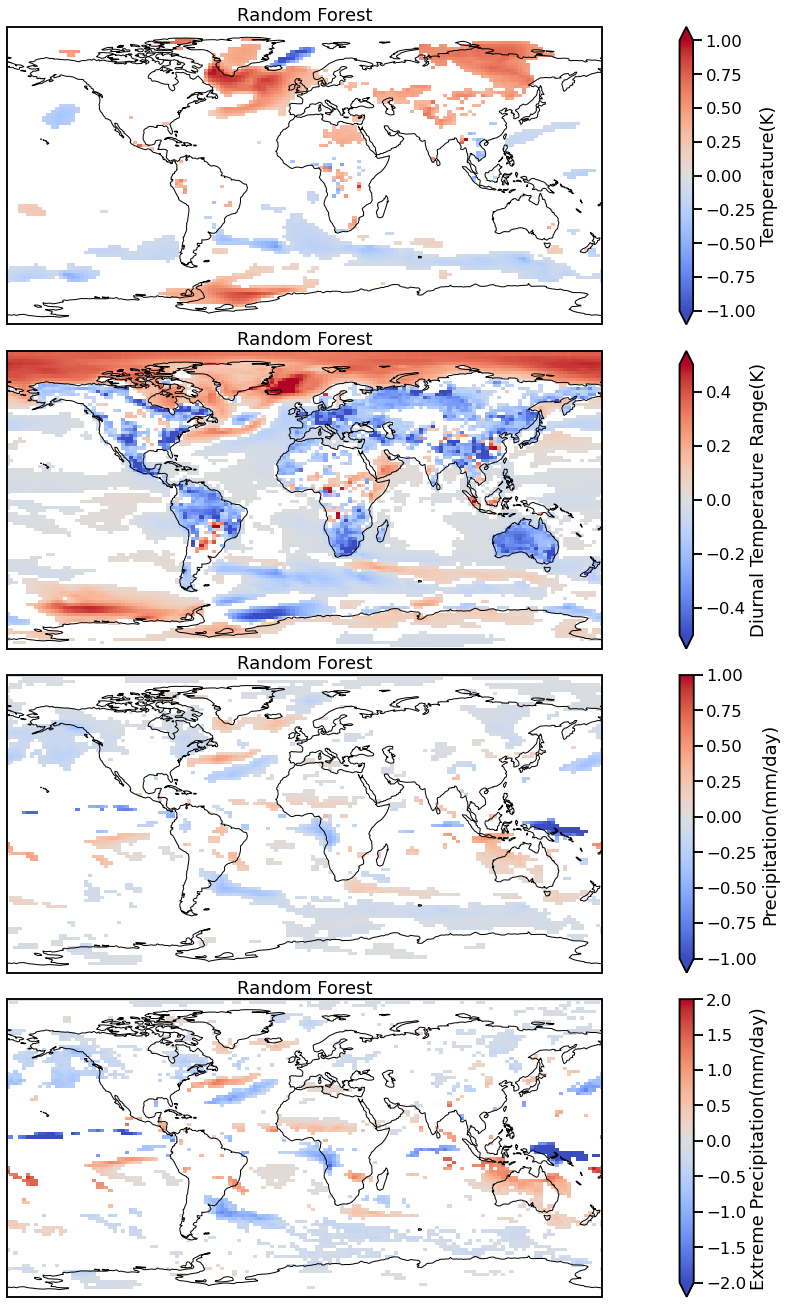

In [23]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    for i in range(4):
        out = output_vars[i]
        ax = axes[i]
        diff = xr_output[out][-21:] - Ytest[out][-21:]
        kws = kwargs[i]
        label = labels[i]
        
        ax.set_title('Random Forest')
        mean_diff = diff.mean('time')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
        
        
        mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
        ax.coastlines()